In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

## Proste obwody kwantowe

In [24]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit import Aer 

qreg = QuantumRegister(2)
creg = ClassicalRegister(2)
# utworzenie obwodu kwantowego z 2 qubitami i 2 bitami
circuit = QuantumCircuit(qreg, creg)
circuit.h(qreg[0]) # działamy bramką na pierwszym qubicie
circuit.measure(qreg, creg) # dokunujemy pomiaru

# zdefiniowanie symulatora
simulator = Aer.get_backend('qasm_simulator')
# definicja zadania do wykonania
job = execute(circuit, simulator, shots=1000)
# wyciągnięcie wyników i statystyk
result = job.result()
counts = result.get_counts(circuit)
print(counts)

{'01': 495, '00': 505}


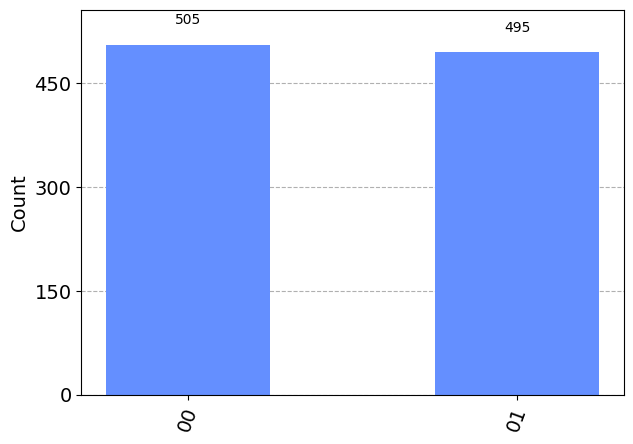

In [25]:
from qiskit.visualization import plot_histogram
display(plot_histogram(counts))

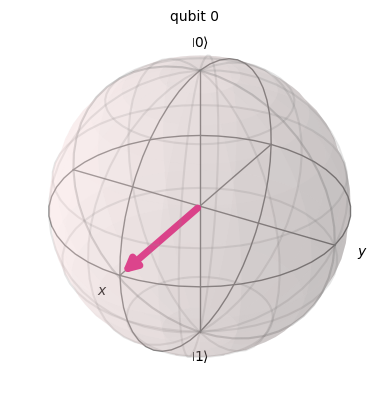

In [27]:
qr = QuantumRegister(1)
qc = QuantumCircuit(qr)
qc.h(qr[0])

# klasyczny symulator pozwala zobaczyc stan
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(result.get_statevector())


## Dwa kubity

In [28]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.h(qr[1])
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
state = result.get_statevector()
state.draw('latex')

<IPython.core.display.Latex object>

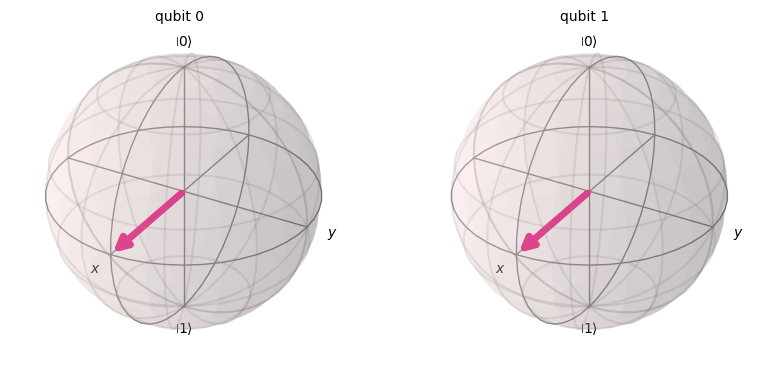

In [29]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(result.get_statevector())

## Inny stan dwóch kubitów

In [30]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(0,1)

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
state = result.get_statevector()

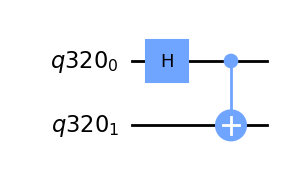

In [31]:
qc.draw('mpl')

In [32]:
state.draw('latex')

<IPython.core.display.Latex object>

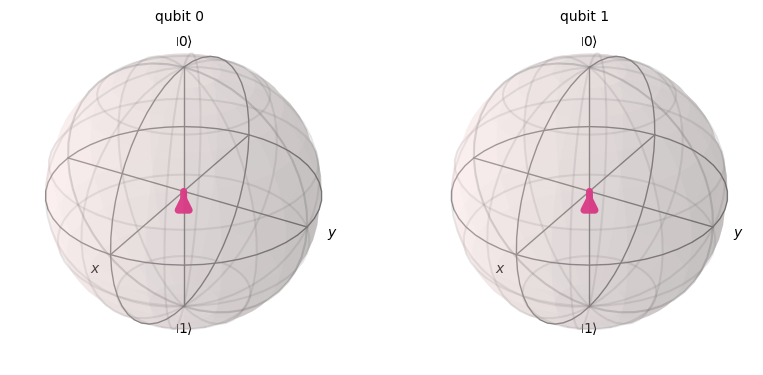

In [33]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(result.get_statevector())

## losowy klasyfikator

In [34]:
import random
random.seed(42)

# losowa funkcja klasyfikująca
def classify(iris):
    return random.randint(0,1)

# pomocnicza funkcja
def run(f_classify, x):
    return list(map(f_classify, x))

def evaluate(predictions, actual):
    correct = list(filter(
        lambda item: item[0] == item[1],
        list(zip(predictions, actual))
    ))
    return f"{len(correct)} poprawnych przewidywan z {len(actual)}. Accuracy ({len(correct)/len(actual)*100:.0f}%)"


from sklearn.datasets import load_iris
iris = load_iris()

evaluate(run(classify, iris.data[:100]), iris.target[:100])

'58 poprawnych przewidywan z 100. Accuracy (58%)'

In [35]:
evaluate(run(classify, iris.data[:100]), iris.target[:100])

'45 poprawnych przewidywan z 100. Accuracy (45%)'

In [36]:
import numpy as np
np.array([[int(evaluate(run(classify, iris.data[:100]), iris.target[:100]).split()[0]) for _ in range(2)] for _ in range(34)]).mean()

50.98529411764706

In [37]:
from math import sqrt
qc = QuantumCircuit(1)
state = [1/sqrt(2), 1/sqrt(2)]
qc.initialize(state, 0)
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
state = result.get_statevector()
state.draw('latex')

<IPython.core.display.Latex object>

In [38]:
from qiskit import execute, Aer, QuantumCircuit
from math import sqrt 

def quantum(iris_state):
    qc = QuantumCircuit(1)
    state = [1/sqrt(2), 1/sqrt(2)]
    qc.initialize(state, 0)
    qc.measure_all()

    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=1).result()
    counts = result.get_counts()
    
    return int(list(map(lambda item: item[0], counts.items()))[0])


evaluate(run(quantum, iris.data[:100]), iris.target[:100])

'54 poprawnych przewidywan z 100. Accuracy (54%)'

## Quantum Machine Learning

Optymalizacja jest jednym z elementów uczenia maszynowego.

Trening GPT-3 wymagałby 355 lat trenowania na pojedynczym GPU i kosztowałby 4.6 mln $\$$

Jednak zanim przejdziemy do optymalizacji zastanówmy się jak przekształcić nasze klasyczne dane tak by były zrozumiałe dla komputera kwantowego. 

![](img/dane.png)

Aktualnie wciąz znajdujemy się w epoce NISQ `Noisy Intemediate-Scale Quantum machines`. 

W celu zaprezentowania mozliwości komputerów kwantowych w procesach ML i optymalizacji powstała dziedzina algorytmów łączących w sposób hybrydowy klasyczne metody optymalizacyjne wraz z mszynami kwantowymi.


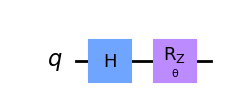

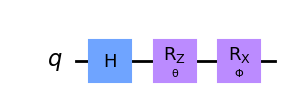

In [39]:
from qiskit.circuit import QuantumCircuit, Parameter
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)
display(qc_A.draw('mpl'))
# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)
display(qc_B.draw('mpl'))

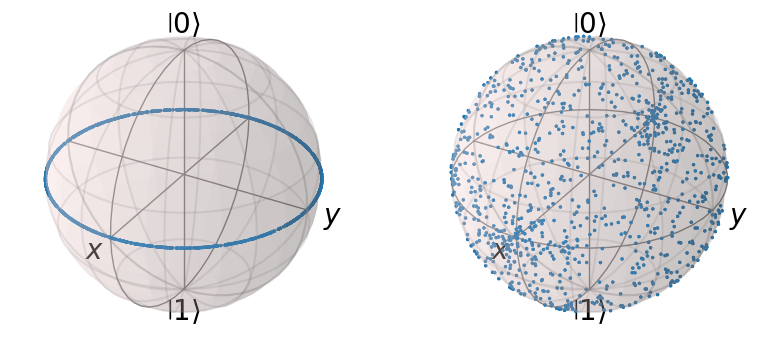

In [40]:
# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

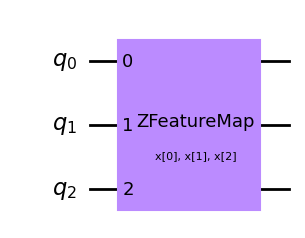

In [41]:
from qiskit.circuit.library import ZFeatureMap

qc_z = ZFeatureMap(feature_dimension=3, reps=1)
qc_z.draw('mpl')

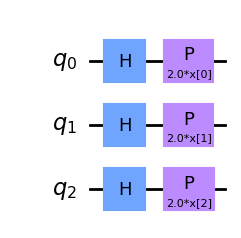

In [42]:
qc_z.decompose().draw('mpl')


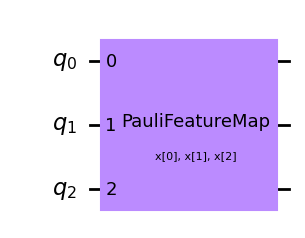

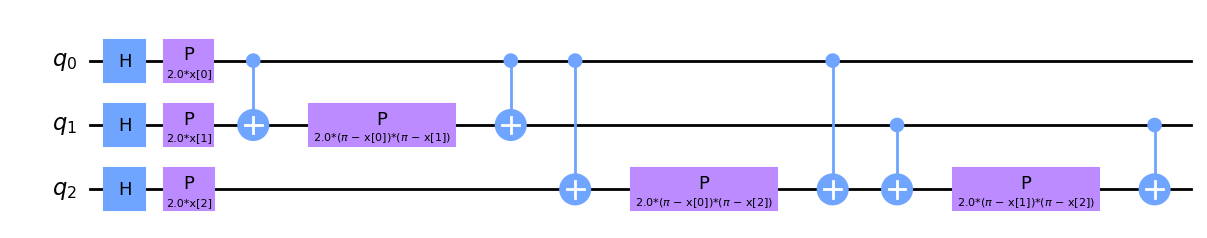

In [43]:
from qiskit.circuit.library import PauliFeatureMap
qc_p = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['Z','ZZ'])
display(qc_p.draw('mpl'))
qc_p.decompose().draw('mpl')

## Variational Quantum Algorithms
 
Hybrydowa pętla VQA wymaga parametryzowanego obwodu kwantowego (uruchamianego na komputerze kwantowym) oraz klasycznego optymalizatora potrafiącego aktualizować wartość parametrów. 

Zastosowania w:
- kwantowe symulacje w chemii 
- optymalizacja portfolio
- klasyfikacja i regresja

![](img/VQA.png)

In [44]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split



iris = load_iris()
labels = iris.target

features = iris.data
features = MinMaxScaler().fit_transform(features)

df = pd.DataFrame(features, columns=iris.feature_names)
df['class'] = pd.Series(iris.target)

X = df.drop('class', axis=1).values
y = df['class'].values
num_features = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [45]:
# KODOWANIE DANYCH 
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

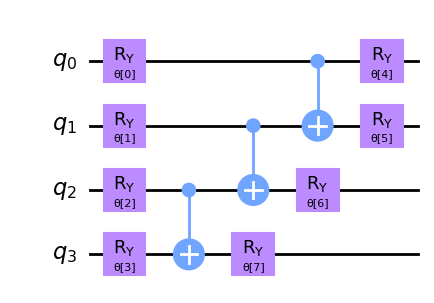

In [46]:

# WYBOR OBWODU PARAMETRYZOWANEGO JAKO MODEL ML 
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl")

In [47]:
# OPTYMALIZATOR i SAMPLER

from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

optimizer = COBYLA(maxiter=100)
sampler = Sampler()

In [48]:
## pomocnicza funkcja do wizualizacji wyników

from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

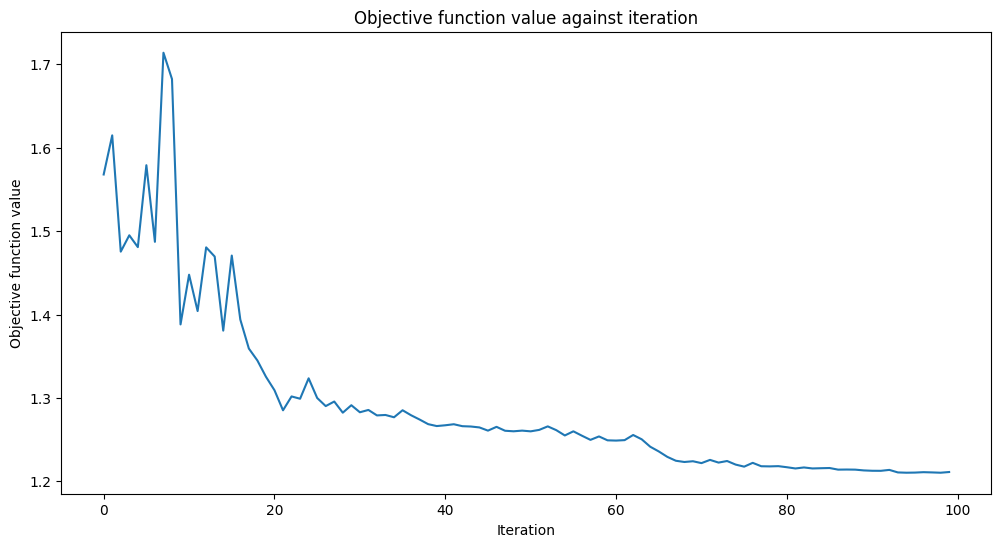

Czas uczenia: 34 sekund


In [49]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X, y)
elapsed = time.time() - start

print(f"Czas uczenia: {round(elapsed)} sekund")

In [50]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.67
